# fit_ellipses
- Given a video and events file, fits an ellipse to every detection when possible
- Outputs a file of the fits, with each row corresponding to a different event
- The file structure looks like:

    - (fitting parameters)
    - [event num, [[ellipse center x, ellipse center y], [ellipse axis 1, ellipse axis 2], ellipse angle for detection 1], [detection 2...], etc.]

# Imports

In [33]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [34]:
date = '7-19-2017/'
particle = '293-T/'
channel = '15-30-15_3/'
file_index = '1'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events_filtered.json'

In [35]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

# Load template and create stage

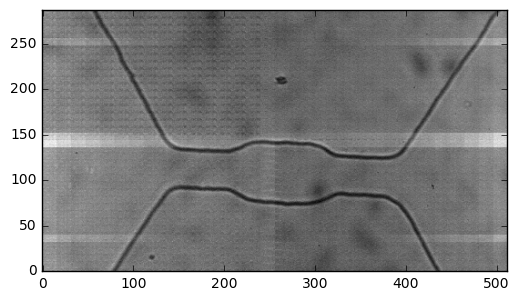

In [36]:
template_index = 1500

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.04540766  0.99896854]


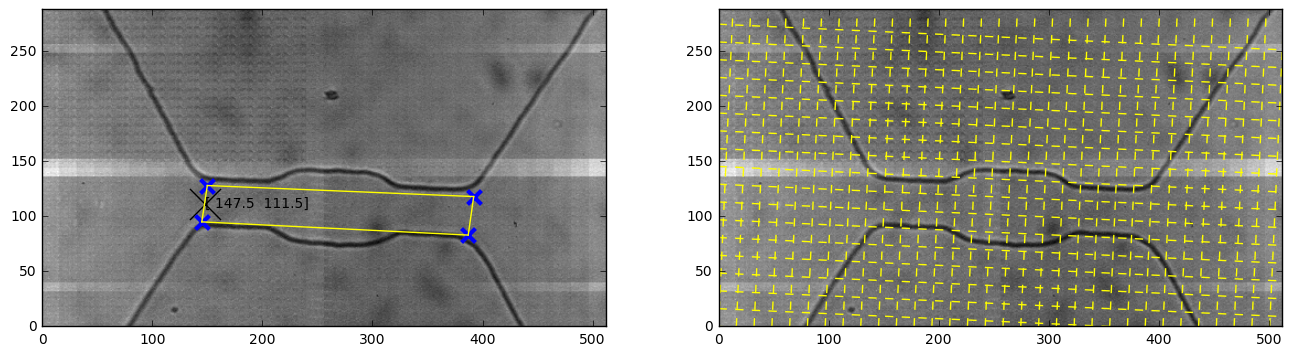

In [37]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)
c0 = [150, 128]
c1 = [145, 95]
c2 = [387, 83] 
c3 = [392, 118]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Define functions

In [40]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

preprocessing_steps = []
def preprocess_fit_ellipse(raw_frame, raw_template_frame, detection):

    
    
    
    # Refresh list
    del preprocessing_steps[:]

    

    
    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])
    
    template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    

    #################################
    # Crop
    #################################
    
    crop_distance = 30
    
    preprocessing_steps.append(['crop'] + [crop_distance])

    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    template_frame = crop_frame(template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(processed_frame - template_frame)



    #################################
    # Blur
    #################################


    blur_kernel = (9,9)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))




    #################################
    # Threshold
    #################################

    threshold = .25
    
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)





    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)


    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)

        
    
 


    ###################################
    # Fit ellipse
    ###################################


    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[1], cell_pixels[0])

    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = oi.get_ellipse_center(ellipse, offset = (detection._px - crop_distance, detection._py - crop_distance))

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

 
        
        
        
        
        
    
        
        
    return [ellipse_center_adjusted[0], ellipse_center_adjusted[1], ellipse_axes_lengths[0], ellipse_axes_lengths[1], ellipse_angle]
        


# Preprocess, fit ellipse to all detections, calculate aspect ratios at every frame

In [41]:
ellipsess = []
detection_indicess = []


for i, oi_event in enumerate(oi_events):
    print 'event', i, '/', len(oi_events)
    
    
    ellipsess.append([])
    detection_indicess.append([])
    
    
    for j, detection in enumerate(oi_event._detections):
        
        try:

            # Get raw frame
            frame = oi_vid.get_frame(detection._tf)

            # Preprocess and fit ellipse
            ellipse = preprocess_fit_ellipse(frame, template_frame, detection)



            ellipsess[-1].append([j] + ellipse)

            
        except:
            
            print '\tfailed on', j, '/', len(oi_event._detections)

event 0 / 8
	failed on 0 / 145
	failed on 1 / 145
	failed on 2 / 145
	failed on 3 / 145
	failed on 4 / 145
	failed on 5 / 145
	failed on 6 / 145
	failed on 7 / 145
	failed on 8 / 145
	failed on 9 / 145
	failed on 10 / 145
	failed on 11 / 145
	failed on 12 / 145
	failed on 13 / 145
	failed on 14 / 145
	failed on 15 / 145
	failed on 16 / 145
	failed on 17 / 145
	failed on 18 / 145
	failed on 19 / 145
	failed on 20 / 145
	failed on 21 / 145
	failed on 22 / 145
	failed on 23 / 145
	failed on 24 / 145
	failed on 25 / 145
	failed on 26 / 145
	failed on 27 / 145
event 1 / 8
	failed on 0 / 122
	failed on 1 / 122
	failed on 2 / 122
	failed on 3 / 122
	failed on 4 / 122
	failed on 5 / 122
	failed on 6 / 122
	failed on 7 / 122
	failed on 8 / 122
	failed on 9 / 122
	failed on 10 / 122
	failed on 11 / 122
	failed on 12 / 122
	failed on 13 / 122
	failed on 14 / 122
	failed on 15 / 122
	failed on 16 / 122
	failed on 17 / 122
	failed on 18 / 122
event 2 / 8
	failed on 0 / 142
	failed on 1 / 142
	faile

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:531: RuntimeWarning: invalid value encountered in sqrt
  res1=np.sqrt(up/down1)
/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:532: RuntimeWarning: invalid value encountered in sqrt
  res2=np.sqrt(up/down2)


event 5 / 8
	failed on 0 / 139
	failed on 1 / 139
	failed on 2 / 139
	failed on 3 / 139
	failed on 4 / 139
	failed on 5 / 139
	failed on 6 / 139
	failed on 7 / 139
	failed on 8 / 139
	failed on 9 / 139
	failed on 10 / 139
	failed on 11 / 139
	failed on 12 / 139
	failed on 13 / 139
	failed on 14 / 139
	failed on 15 / 139
	failed on 16 / 139
	failed on 17 / 139
	failed on 18 / 139
	failed on 19 / 139
	failed on 20 / 139
	failed on 21 / 139
	failed on 22 / 139
	failed on 23 / 139
	failed on 24 / 139
	failed on 25 / 139
event 6 / 8
	failed on 0 / 138
	failed on 1 / 138
	failed on 2 / 138
	failed on 3 / 138
	failed on 4 / 138
	failed on 5 / 138
	failed on 6 / 138
	failed on 7 / 138
	failed on 8 / 138
	failed on 9 / 138
	failed on 10 / 138
	failed on 11 / 138
	failed on 12 / 138
	failed on 13 / 138
	failed on 14 / 138
	failed on 15 / 138
	failed on 16 / 138
	failed on 17 / 138
	failed on 18 / 138
	failed on 19 / 138
	failed on 20 / 138
	failed on 21 / 138
event 7 / 8
	failed on 0 / 100
	fail

# Save ellipses

In [42]:
output_file_path = '../data/' + date + particle + channel + 'ellipses_' + file_index

In [43]:
with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write preprocessing steps
    file_writer.writerow(preprocessing_steps)
    
    # Write ellipse info
    file_writer.writerow(['detection index', 'ellipse center x', 'ellipse center y', 'ellipse axes x', 'ellipse axes y', 'ellipse angle'])
    
    # Write ellipse
    for i, ellipses in enumerate(ellipsess):
        file_writer.writerow(['event #', i])
        for ellipse in ellipses:
            file_writer.writerow(ellipse)